**Kelvin Fung**<br>
**YSC4216 Machine Learning**<br>
**Assignment 2: Regression Using MAP and Basis Functions**

Link to assignment:
    
https://tanrobby.github.io/teaching/ync_machine_learning/assignment3.html

# Part 1: Full Bayesian Inference 

1. Generate 50 2D-data points using the following function: $y = sin(x^2 + 1)$
2. Add Gaussian random noise to the data
3. Show original curve line and the noisy data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

%matplotlib inline

In [2]:
# Functions to generate data
def actual_distribution(num_points=50):
    x_act = np.linspace(0, 1, num=num_points)
    y_act = np.sin(np.power(x_act, 2) + 1)
    
    return (x_act, y_act)

def add_noise(y_act, sig=.05):
    mu = 0
    noise = np.random.normal(mu, sig, len(y_act))
    
    return y_act + noise

In [3]:
x_act, y_act = actual_distribution(50)
y_noise = add_noise(y_act, .05)

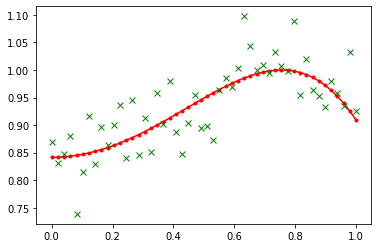

In [4]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(x_act, y_act, '-ro', markersize=3, label='Original curve')
ax.plot(x_act, y_noise, '-gx', linestyle='none', label='Noisy data')

4. Compute w based on full Bayesian Inference (by using basis functions like discussed in class).
5. Display the estimated values of w

In [5]:
def gaussian_basis(x, miu, sigma):
        return np.exp(-np.power(x-miu, 2) / (2*np.power(sigma, 2)))

In [6]:
def full_bayesian(x_act, y_noise, M, basis_function, alpha=0, beta=1):
    
    s = 1 / M
    mu_values = [s*i for i in range(1, M)]
    
    phi = np.matrix([[1] + [basis_function(x, mu, s) for mu in mu_values]
                     for x in x_act])
    
    s_n = linalg.inv(np.diag([alpha for _ in range(M)]) + beta*phi.T*phi)
    
    m_n = beta * s_n * phi.T * np.matrix(y_noise).T
    
    y_est = phi*m_n
    
    return m_n, y_est

In [7]:
w, y_est = full_bayesian(x_act, y_noise, 5, gaussian_basis, .5, 5)

In [8]:
w

matrix([[0.76022477],
        [0.09738483],
        [0.02096095],
        [0.05782242],
        [0.22178526]])

6. Experiment with your code by changing alpha and beta. Discuss the meaning of them with respect to the curve fitting results.

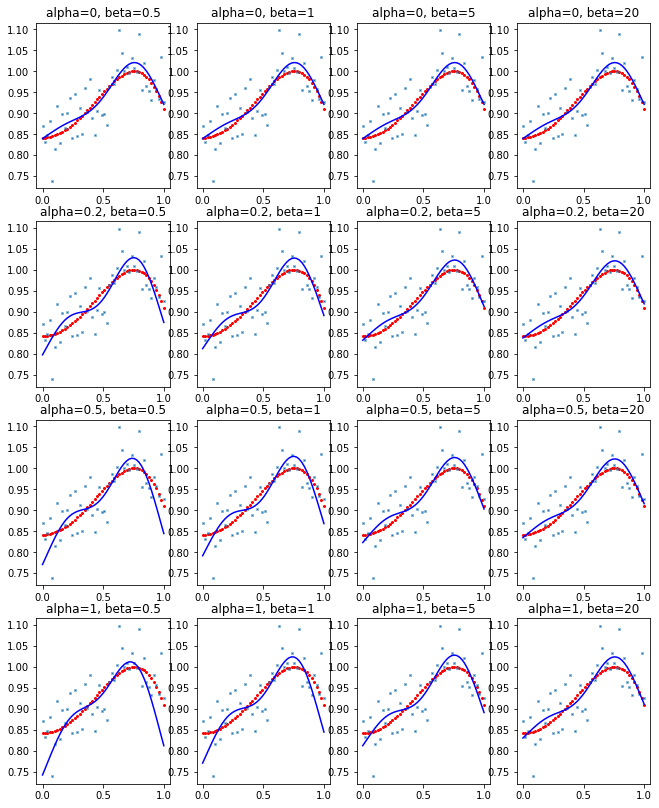

In [9]:
alpha_values = [0, 0.2, 0.5, 1]
beta_values = [0.5, 1, 5, 20]
plot_num = 1

fig = plt.figure(figsize=[11, 14])
for alpha in alpha_values:
    for beta in beta_values:
        _, y_est = full_bayesian(x_act, y_noise, 5, gaussian_basis, alpha, beta)
        
        ax = fig.add_subplot(4, 4, plot_num)
        plot_num += 1
        
        ax.plot(x_act, y_act, 'ro', markersize=2)   # Original curve
        ax.plot(x_act, y_noise, 'x', markersize=2)  # Noisy data
        ax.plot(x_act, y_est, 'b')                  # Fitted curve
        
        ax.set(title="alpha={}, beta={}".format(alpha, beta))


7. Show your best fitting:

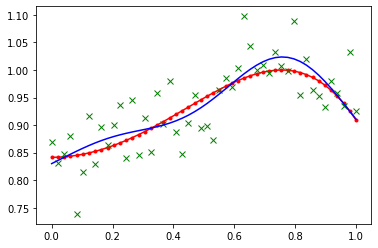

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(x_act, y_act, '-ro', markersize=3, label='Original curve')
ax.plot(x_act, y_noise, '-gx', linestyle='none', label='Noisy data')
ax.plot(x_act, y_est, 'b', label='Predicted curve')

8. Increase the value of M, and discuss how it affects the prediction (curve fitting) and the uncertainty of the prediction.

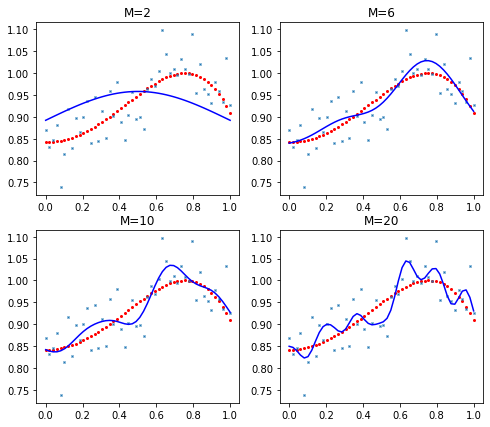

In [12]:
M_values = [2, 6, 10, 20]
plot_num = 1

fig = plt.figure(figsize=[8, 7])
for M in M_values:
    
    _, y_est = full_bayesian(x_act, y_noise, M, gaussian_basis, .5, 10)
    
    ax = fig.add_subplot(2,2, plot_num)
    plot_num += 1
        
    ax.plot(x_act, y_act, 'ro', markersize=2)   # Original curve
    ax.plot(x_act, y_noise, 'x', markersize=2)  # Noisy data
    ax.plot(x_act, y_est, 'b')                  # Fitted curve

    ax.set(title="M={}".format(M))

At M=2, the predicted curve does not fit well into the underlying curve. At M=10 and M=20, we observe overfitting, where the predicted curve tries to fit the noisy data too closely. At M=6, however, we obtain a predicted curve that fits the underlying curve decently well.

9. Explain how useful p(w|t) is for the training and testing stages.

$p(w|t)$ is useful in the training stage as it tells us how certain or uncertain we are about *w*, which are parameters of the model

# Part 2 - Sequential Bayesian Learning

1. Generate 50 2D-data points using the following function: $y = sin(x^2 + 1)$
2. Add Gaussian random noise to the data

In [14]:
x_act, y_act = actual_distribution(50)
y_noise = add_noise(y_act, .05)

3. Fit the generated noisy data sequentially (5 data for each sequence).

In [50]:
def sequential_bayesian(x_act, y_noise, M, basis_function, alpha=0, beta=1):
    
    # Create array to store order in which data is sampled.
    sampling_order = [x for x in range(50)]
    np.random.shuffle(sampling_order)
    
    s_lst = []
    w_lst = []
    y_est_lst = []
    
    s = 1 / M
    mu_values = [s*i for i in range(1, M)]
    PHI = np.matrix([[1] + [basis_function(x, mu, s) for mu in mu_values]
                     for x in x_act])

    # First set (regular Full Bayesian)
    x_subset = [x_act[i] for i in sampling_order[:5]]
    y_subset = [y_noise[i] for i in sampling_order[:5]]
    
    phi = np.matrix([[1] + [basis_function(x, mu, s) for mu in mu_values]
                     for x in x_subset])
    
    s_n = linalg.inv(np.diag([alpha for _ in range(M)]) + beta*phi.T*phi)
    m_n = beta * s_n * phi.T * np.matrix(y_subset).T
    y_est = PHI*m_n
    
    s_lst.append(s_n)
    w_lst.append(m_n)
    y_est_lst.append(y_est)
    
    # Subsequent sets    
    sequence_num = 2
    while sequence_num <= 10:
        x_subset = [x_act[i] for i in sampling_order[(sequence_num-1)*5:(sequence_num*5)]]
        y_subset = [y_noise[i] for i in sampling_order[(sequence_num-1)*5:(sequence_num*5)]]

        phi = np.matrix([[1] + [basis_function(x, mu, s) for mu in mu_values]
                         for x in x_subset])
        
        s_n = linalg.inv(linalg.inv(s_lst[sequence_num-2]) + beta*phi.T*phi)
        m_n = s_n * (linalg.inv(s_lst[sequence_num-2]) * w_lst[sequence_num-2] + \
                     beta*phi.T*np.matrix(y_subset).T)
        y_est = PHI*m_n
        
        s_lst.append(s_n)
        w_lst.append(m_n)
        y_est_lst.append(y_est)
        
        sequence_num += 1
        
    return w_lst, y_est_lst

In [51]:
w_lst, y_est_lst = sequential_bayesian(x_act, y_noise, 6, gaussian_basis, 0.5, 5) 

4. Show your best result for each sequence. The below examples are only some of them, but in your submission, you have to show all m.

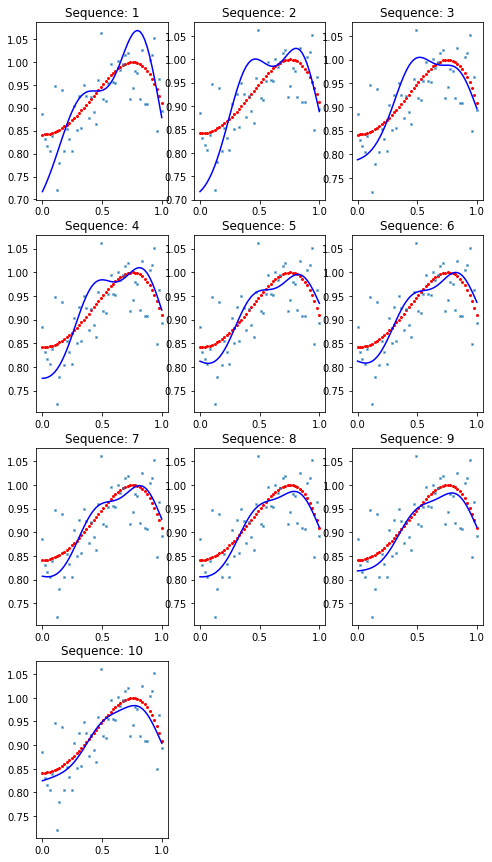

In [54]:
plot_num = 1

fig = plt.figure(figsize=[8, 15])
for y_est in y_est_lst:
        
    ax = fig.add_subplot(4,3, plot_num)
    
    ax.plot(x_act, y_act, 'ro', markersize=2)   # Original curve
    ax.plot(x_act, y_noise, 'x', markersize=2)  # Noisy data
    ax.plot(x_act, y_est, 'b')                  # Fitted curve

    ax.set(title="Sequence: {}".format(plot_num))
    plot_num += 1

5. Discuss how to set M and the basis function's parameters in sequential learning.

# Part 3 - Predictive Distribution 

1. Generate 50 2D-data points using the following function: $y = sin(x^2 + 1)$
2. Add Gaussian random noise to the data
3. Show original curve line and the noisy data

In [55]:
x_act, y_act = actual_distribution(50)
y_noise = add_noise(y_act, .05)

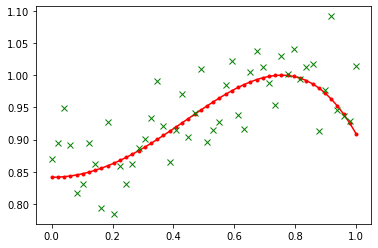

In [56]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(x_act, y_act, '-ro', markersize=3, label='Original curve')
ax.plot(x_act, y_noise, '-gx', linestyle='none', label='Noisy data')

In [132]:
def predictive_dist(x_act, y_noise, M, basis_function, alpha=0, beta=1):
    
    # Create array to store order in which data is sampled.
    sampling_order = [x for x in range(50)]
    np.random.shuffle(sampling_order)
    
    s_lst = []
    w_lst = []
    y_est_lst = []
    y_error_lst = []
    
    s = 1 / M
    mu_values = [s*i for i in range(1, M)]
    PHI = np.matrix([[1] + [basis_function(x, mu, s) for mu in mu_values]
                     for x in x_act])
    
    def y_pred_and_error(x_act, w, s):
        
        y_pred = []
        error = []
        
        for x in x_act:
            
            phi_vec = np.matrix([[1] + [basis_function(x, mu, s) 
                                             for mu in mu_values]]).T
            y_val = (w.T * phi_vec)
            error_val = (1/beta + phi_vec.T * s * phi_vec)
            print("y_val shape: {}, error_val shape: {}".format(y_val.shape, error_val.shape))
            y_pred.append(y_val.item())
            error.append(error_val.item())
            
        print(y_pred)
        return y_pred, error
    
    for sequence, index in enumerate(sampling_order):
        
        # First sequence
        if len(w_lst) == 0:
            phi = np.matrix([[1] + [basis_function(x_act[index], mu, s) for mu in mu_values]])
    
            s_n = linalg.inv(np.diag([alpha for _ in range(M)]) + beta*phi.T*phi)
            m_n = beta * s_n * phi.T * np.matrix(y_noise[index])
            
            y_pred, y_error = y_pred_and_error(x_act, m_n, s_n)
            s_lst.append(s_n)
            w_lst.append(m_n)
            y_est_lst.append(y_pred)
            y_error_lst.append(y_error)      
    

        # Subsequent sequences
        else:
            phi = np.matrix([[1] + [basis_function(x_act[index], mu, s) for mu in mu_values]])
            
            s_n = linalg.inv(linalg.inv(s_lst[sequence-1]) + beta*phi.T*phi)
            m_n = s_n * (linalg.inv(s_lst[sequence-1]) * w_lst[sequence-1] + \
                         beta*phi.T*np.matrix(y_noise[index]))
            
            #y_pred, y_error = y_pred_and_error(x_act, m_n, s_n)
            s_lst.append(s_n)
            w_lst.append(m_n)
            y_est_lst.append(y_pred)
            y_error_lst.append(y_error)    
            
    return y_est_lst, y_error_lst    

In [133]:
y_est_lst, y_error_lst = predictive_dist(x_act, y_noise, 6, gaussian_basis, 0.5, 5) 

y_val shape: (1, 1), error_val shape: (1, 1)
y_val shape: (1, 1), error_val shape: (1, 1)
y_val shape: (1, 1), error_val shape: (1, 1)
y_val shape: (1, 1), error_val shape: (1, 1)
y_val shape: (1, 1), error_val shape: (1, 1)
y_val shape: (1, 1), error_val shape: (1, 1)
y_val shape: (1, 1), error_val shape: (1, 1)
y_val shape: (1, 1), error_val shape: (1, 1)
y_val shape: (1, 1), error_val shape: (1, 1)
y_val shape: (1, 1), error_val shape: (1, 1)
y_val shape: (1, 1), error_val shape: (1, 1)
y_val shape: (1, 1), error_val shape: (1, 1)
y_val shape: (1, 1), error_val shape: (1, 1)
y_val shape: (1, 1), error_val shape: (1, 1)
y_val shape: (1, 1), error_val shape: (1, 1)
y_val shape: (1, 1), error_val shape: (1, 1)
y_val shape: (1, 1), error_val shape: (1, 1)
y_val shape: (1, 1), error_val shape: (1, 1)
y_val shape: (1, 1), error_val shape: (1, 1)
y_val shape: (1, 1), error_val shape: (1, 1)
y_val shape: (1, 1), error_val shape: (1, 1)
y_val shape: (1, 1), error_val shape: (1, 1)
y_val shap

In [118]:
y_error_lst[0][0]

array([[5.68565156, 0.94424586, 0.94424586, 0.94424586, 2.22816284,
        6.0543824 ],
       [0.94424586, 7.40278197, 0.94424586, 0.94424586, 0.94424586,
        0.94424586],
       [0.94424586, 0.94424586, 7.40278183, 0.94424586, 0.94424586,
        0.94424586],
       [0.94424586, 0.94424586, 0.94424586, 7.4026585 , 0.94424586,
        0.94424586],
       [2.22816284, 0.94424586, 0.94424586, 0.94424586, 7.38806715,
        1.50476668],
       [6.0543824 , 0.94424586, 0.94424586, 0.94424586, 1.50476668,
        7.04198789]])

ValueError: shape mismatch: objects cannot be broadcast to a single shape

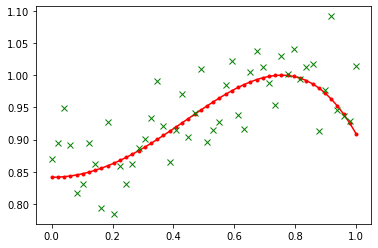

In [83]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(x_act, y_act, '-ro', markersize=3, label='Original curve')
ax.plot(x_act, y_noise, '-gx', linestyle='none', label='Noisy data')
ax.errorbar(x_act, y_est_lst[0], yerr=y_error_lst[0], label='Fitted curve')